In [1]:
import pandas as pd
import re
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_SEED = 322
!pip freeze > requirements.txt

#импортировали исходные данные
df = pd.read_csv('main_task.csv')
df_kaggle = pd.read_csv('kaggle_task.csv')
sample_sumbission = pd.read_csv('sample_submission.csv')
df['sample'] = 1 # помечаем где у нас трейн
df_kaggle['sample'] = 0 # помечаем где у нас тест
df_kaggle['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_kaggle.append(df, sort=False).reset_index(drop=True) # объединяем

data
df = data
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [2]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [3]:
#функции обработки

#считаем % пропусков по каждому признаку
#функция missing_data(data) будет принимать на вход датасет, и определять % пропусков и тип данных
def missing_data(data):
    for i in data.columns:
        md = 100-data[i].isna().value_counts()[0]*100/len(data[i])
        print('% пропусков в',i, md)
    return

#функция конвертации строковых данных в столбце Price Range, на фход идет серия, на выходе числовые значения 
#ghbpyfrf ценовой категории
def price_cat(data):
    if data == '$':
        return 1
    elif data == '$$ - $$$':
        return 2
    elif data == '$$$$':
        return 3

#функция которая получает на вход серию со списком всех кухонь и убирает аартефакты в названиях,
#формируя список 
def resplit(ct):
    ct = ct.replace(", ",'')
    ct = ct.replace("[",'')
    ct = ct.replace("]",'')
    ct = re.split("'(.*?)'",ct)
    ct = list(filter(None, ct))
    return ct

#функция разбивки типов кухонь , нужная для выполенния заданий в модуле
def split_cuisine(ct):
    if re.findall(r"'(.*?)'", ct) == 'Unknown':
        return 'Unknown'
    else:
        return  re.findall(r"'(.*?)'", ct)

#простая функция длинны списка
def len_list(data):
    return len(data)


# функиця разделения даты из отзывов
# тип данных строка, визуально похожая на списки
# необходимо разпарсить данные
# кроме того , в строке есть дата отзыва, ее тоже надо достать
# кол-во дат будет равно кол-ву отзывов

def split_date(ct):
    if re.findall(r'\d\d/\d\d/\d{4}', ct) == 'None':
        return dt.datetime(1900,12,31)
    else:
        return  re.findall(r'\d\d/\d\d/\d{4}', ct)
    
# функция возвращает разницу между первым и последним отзывом в формате datetime
def deltadays(rd):
    if len(rd)>=2:
        a = dt.datetime.strptime(rd[0], '%m/%d/%Y') - dt.datetime.strptime(rd[len(rd)-1], '%m/%d/%Y')
        return a
    else:
        return dt.timedelta(0)

def learn_fit(df, random_state = None):
    #X - данные о ресторанах, Y - целевая переменная
    X = df.drop(['Rating', 'Restaurant_id'], axis = 1)
    y = df['Rating']
    
    # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
    # выделим 20% данных на валидацию (параметр test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    #создаем модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)
    #обучение на тесте
    regr.fit(X_train, y_train)
    
    #используем полученную (обученную модель) для предсказания рейтинга в тестовой сборке
    #полученное значение пишем в отдульную переменную
    y_predict = regr.predict(X_test)
    
    #сравниваем предсказанное значение y_predict с тестовым y_test
    print('MAE Regression:', metrics.mean_absolute_error(y_test,y_predict))
    print('MAE Regression round state:', metrics.mean_absolute_error(y_test,np.round(y_predict*2)/2))
    
    #классификация
    le = LabelEncoder()
    le.fit(y_train)
    classif = RandomForestClassifier(n_estimators = 100, random_state=RANDOM_SEED, n_jobs=-1)
    classif.fit(X_train, le.transform(y_train))
    y_predict = classif.predict(X_test)
    print('MAE Классификация:', metrics.mean_absolute_error(y_test,le.inverse_transform(y_predict)))
    
#    plt.rcParams['figure.figsize'] = (10,10)
#    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
#    feat_importances.nlargest(15).plot(kind='barh')

In [4]:
missing_data(df)

% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 34.721999999999994
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0


In [5]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [6]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.34551783170533173
MAE Regression round state: 0.33384615384615385
MAE Классификация: 0.3828632478632479


In [7]:
#удаляем признак как не влияющий на качество 

#df.drop(columns=['ID_TA'], inplace=True)
#df_kaggle.drop(columns=['ID_TA'], inplace=True)


In [8]:
# City

df.groupby('City').Rating.agg(['mean','std','count']).sort_values(by=['mean'], ascending=False)

,mean,std,count
City,,,
Athens,3.423325,1.734354,776
Rome,3.395326,1.730001,2589
Ljubljana,3.389640,1.664843,222
Oporto,3.338785,1.757784,642
Krakow,3.315884,1.756785,554
Vienna,3.295218,1.703231,1443
Berlin,3.285952,1.757230,2705
Edinburgh,3.270470,1.743363,745
Amsterdam,3.270044,1.753022,1372


In [9]:
#импортируем данные по городам мира, и заберем оттуда только столицы (признак primary)
cities = pd.read_csv('worldcities.csv')
cities = cities[cities['capital']=='primary']

#уберем ненужную информацию и сформируем список столиц мира, хотя нам надо только европу, но все же
cities.drop(['city_ascii', 'lat','lng','capital','id','admin_name'], inplace=True, axis=1)
cities_list=list(cities['city'])

#вводим новый признак Столица, 1 если город столичный, 0 если не столичный
df['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )
df_kaggle['capital']=df['City'].apply(lambda x: 1 if x in cities_list else 0 )
display(df)

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,1
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,1


Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.323343432030932
MAE Regression round state: 0.31017094017094016
MAE Классификация: 0.35341880341880344


In [10]:
#получаем список уникальных городов
city_list=df['City'].unique()

#попробуем добавить численность населения
city_list={'Paris':2.148, 'Stockholm':0.975, 'London':8.961, 'Berlin':3.669, 'Munich':1.488, 'Oporto':0.287,
       'Milan':1.1399, 'Bratislava':0.428, 'Vienna':1.921, 'Rome':2.790, 'Barcelona':1.664, 'Madrid':3.334,
       'Dublin':1.173, 'Brussels':1.212, 'Zurich':0.434, 'Warsaw':1.793, 'Budapest':1.750, 'Copenhagen':0.794,
       'Amsterdam':0.860, 'Lyon':0.518, 'Hamburg':1.845, 'Lisbon':0.506, 'Prague':1.335, 'Oslo':0.693,
       'Helsinki':0.655, 'Edinburgh':0.488, 'Geneva':0.201, 'Ljubljana':0.286, 'Athens':0.664,
       'Luxembourg':0.644, 'Krakow':0.779}
df['population'] = df.City.replace(to_replace=city_list)


In [11]:
#проверяем модель

In [12]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18134871794871793
MAE Regression round state: 0.16042735042735043
MAE Классификация: 0.18012820512820513


In [13]:
#Отлично!!! модель улучшена почти в 2 раза, играем дальше


In [14]:
#узнаем модальное значение для категории Price Range
#rjnjhsv позже заполним пропуски
print('Модальное значение для категории Price Range',df['Price Range'].mode()[0])



range_replace={'$':1, '$$ - $$$':2, '$$$$':3}

df['Price Range']=df['Price Range'].replace(to_replace=range_replace)

#заменим пропуски модальным значением
df['Price Range'].fillna(2, inplace=True, axis=0)

#делаем тоже самое с кэгл
#df_kaggle['Price Range']=df_kaggle['Price Range'].replace(to_replace=range_replace)
#df_kaggle['Price Range'].fillna(2, inplace=True, axis=0)

#проверяем пропуски
missing_data(df)

#проверяем модель , уже не удаляем столбец Price Range т.к. мы его изменили 
drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Модальное значение для категории Price Range $$ - $$$
% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в Cuisine Style 23.180000000000007
% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в Number of Reviews 6.400000000000006
% пропусков в Reviews 0.0040000000000048885
% пропусков в URL_TA 0.0
% пропусков в ID_TA 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.18066965811965813
MAE Regression round state: 0.16004273504273503
MAE Классификация: 0.1838034188034188


In [15]:
#есть  небольшое улучшение 


In [16]:
#Добавим признак цены в городе

price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
df['Price in City'] = df['City'].map(price_in_city_dict)


In [17]:
#опять проверяем модель

drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с базовыми признаками до очистки и генерации новых

MAE Regression: 0.17832008547008546
MAE Regression round state: 0.1579059829059829
MAE Классификация: 0.17884615384615385


In [18]:
#Попробуем поиграть с кухнями

#добавили количество кухонь в ресторане? это данные внешнего парсинга сайта tripadvisor
#т.к. scraping занимает много времени, его провели отдельным проектом, а здесь только импортируем результаты
#xnj бы сократить время
cuisine = pd.read_csv('cuisine.csv')
#missing_data(cuisine)
#видим что удалось убрать пропуски в признаке Cuisine Style
#теперь заменим данные на данные парсинга и сразу посчитаем кол-во кухонь в ресторане создав новый признак

#применяем функцию которая создает списки кухонь в признаке без артефактов в строковых значениймх
df['Cuisine Style'] = cuisine['Cuisine Style'].apply(resplit)

#считаем кол-во кухонь в каждом ресторане
df['col_cuisine'] = df['Cuisine Style'].apply(len)


#проверим результат добавления нового признака
#drop_columns = ['City','Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)
#видим что есть улучшение, оставляем признак col_cuisine

#посчиатем сколько уникальных кухонь есть в принципе

unique_cuisine = df['Cuisine Style'].explode().unique()
unique_cuisine

#добавим признак соотношения кол-ва кухонь в ресторане к макс кол-ву кухонь в городе

dict = pd.DataFrame(df.groupby('City')['Cuisine Style'].agg('sum'))
#display(dict)
dict['city_col_cuisine']=0

#импортируем нужные библиотеки для подсчета уникальных элементов в списке
from  more_itertools import unique_everseen

#считаем кол-во уникальных кухонь в каждом городе

for i in range(0,len(dict)):
    dict['city_col_cuisine'][i]=len(list(unique_everseen(dict['Cuisine Style'][i])))

dict_a = pd.DataFrame()

for i in range(0,len(dict)):
    new_row = {'city':dict.index[i], 'city_col_cuisine':dict.values[i][1]} 
    dict_a = dict_a.append(new_row, ignore_index=True)

new_dict = dict_a.set_index('city').T.to_dict('list')

#lj,fdkztv новый признак 'city_col_cuisine' - кол-во уникальных куонь в каждом городе
df['city_col_cuisine'] = df['City'].replace(to_replace=new_dict)



<ipython-input-18-3eb58b031075>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict['city_col_cuisine'][i]=len(list(unique_everseen(dict['Cuisine Style'][i])))


In [19]:
#lj,fdbv новый признак, нормировка кухонь относительно каждого города
df['cuisine_norm']=df['col_cuisine']/df['city_col_cuisine']
df

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
print('Смотрим на предикт новых признаков\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт новых признаков

MAE Regression: 0.1770136752136752
MAE Regression round state: 0.15376068376068375
MAE Классификация: 0.17756410256410257


In [20]:
#есть небольшое улучшение 
df['City'].value_counts().to_dict()

{'London': 7193,
 'Paris': 6108,
 'Madrid': 3813,
 'Barcelona': 3395,
 'Berlin': 2705,
 'Milan': 2694,
 'Rome': 2589,
 'Prague': 1816,
 'Lisbon': 1647,
 'Vienna': 1443,
 'Amsterdam': 1372,
 'Brussels': 1314,
 'Hamburg': 1186,
 'Munich': 1145,
 'Lyon': 1126,
 'Stockholm': 1033,
 'Budapest': 1021,
 'Warsaw': 925,
 'Dublin': 836,
 'Copenhagen': 819,
 'Athens': 776,
 'Edinburgh': 745,
 'Zurich': 685,
 'Oporto': 642,
 'Geneva': 590,
 'Krakow': 554,
 'Oslo': 488,
 'Helsinki': 475,
 'Bratislava': 380,
 'Luxembourg': 263,
 'Ljubljana': 222}

In [21]:
#создадим признак, кол-во ресторанов в городе
per_city_dict = df['City'].value_counts().to_dict()
per_city_dict
df['city_restaurants'] = df.City.map(per_city_dict)

# Добавим признак - нормализованный ранг ranking_norm
df['ranking_norm'] = df.Ranking / df.city_restaurants

drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)


Смотрим на предикт с новыми признаками

MAE Regression: 0.17685940170940173
MAE Regression round state: 0.15367521367521367
MAE Классификация: 0.16350427350427352


In [22]:
#отношение кол-ва кухонь в ресторане к среднему кол-ву кухонь в этом городе

# !!!! - данный признак привел к ухудшению оценки, поэтому все закооментировано
# что бы в дальнейшем не было мыслей считать похожие признаки

#mean_city_cuisine = df.groupby('City')['col_cuisine'].mean().to_dict()
#mean_city_cuisine

#df['mcc'] = df.City.replace(to_replace=mean_city_cuisine)
#df['mcc_norm_by_city']=df['col_cuisine']/df['mcc']
#
#drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']
#print('Смотрим на предикт с новым признаком\n')
#learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [23]:
#missing_data(df)
#остались пропуски в Number of reviews

nor  = df.groupby('City')['Number of Reviews'].mean().to_dict()
nor

#добавили новый признак nor - среднее кол-во отзывов по городу
df['nor']=df['City'].replace(to_replace=nor)

#проверяем модель
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)


Смотрим на предикт с новыми признаками

MAE Regression: 0.17524444444444442
MAE Regression round state: 0.15282051282051282
MAE Классификация: 0.16230769230769232


In [65]:
df.drop(['Number of Reviews'],  inplace=True, axis =1 )

In [25]:
#есть улучшение - оставляем

#сделаем копию датасета перед проверкой dummy что бы не перегружать весь датасет и весь код

backup=df

backup.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,ranking_norm,nor
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981,2,114.0,0.017544,6108,2.122299,117.040915
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0.655,1.911579,5,80.0,0.062500,475,0.223158,66.020134
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0.488,1.766443,1,73.0,0.013699,745,1.087248,237.711326


In [27]:
#делаем dummy
df = backup

In [29]:
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,ranking_norm,nor
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1,2.148,1.926981,2,114.0,0.017544,6108,2.122299,117.040915
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1,0.655,1.911579,5,80.0,0.062500,475,0.223158,66.020134
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0.488,1.766443,1,73.0,0.013699,745,1.087248,237.711326


In [35]:
style = df['Cuisine Style'].explode()
X = pd.get_dummies(style)
index_list = pd.Index.tolist(X.index)
Y = X.groupby(index_list).sum()
df = df.join(Y)
style.unique()
X
index_list
Y
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,1,1,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,1,0,0,0,0,0,0,0,0
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,1,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,1,1,0,0,0,0,0,0,0,0
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,0,1,0,0,0,0,0,0,0,0
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,0,0,0,0,0,0,0
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,1,0,0,0,0,0,0,0,0


In [36]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

Смотрим на предикт с новыми признаками

MAE Regression: 0.17228376068376067
MAE Regression round state: 0.1491025641025641
MAE Классификация: 0.1791880341880342


In [ ]:
# Отличный результат, мы улучшили показатели добавиви дамми переменные по типу уникальных кухонь


In [99]:
df_pars = pd.read_csv('df_pars.csv')
missing_data(df_pars)

% пропусков в Unnamed: 0 0.0
% пропусков в Restaurant_id 0.0
% пропусков в City 0.0
% пропусков в URL_TA 0.0
% пропусков в Number of Reviews 0.0


In [100]:
df_pars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Restaurant_id      50000 non-null  object 
 2   City               50000 non-null  object 
 3   URL_TA             50000 non-null  object 
 4   Number of Reviews  50000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [101]:
backup=df




In [103]:
df['Number of REviews']=df_pars['Number of Reviews']


% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0
% пропусков в nor 0.0
% пропусков в Afghani 0.0
% пропусков в African 0.0
% пропусков в Albanian 0.0
% пропусков в American 0.0
% пропусков в Arabic 0.0
% пропусков в Argentinean 0.0
% пропусков в Armenian 0.0
% пропусков в Asian 0.0
% пропусков в Australian 0.0
% пропусков в Austrian 0.0
% пропусков в Azerbaijani 0.0
% пропусков в Bakeries 0.0
% пропусков в Balti 0.0
% пропусков в Bangladeshi 0.0
% пропусков в Bar 0.0
% пропусков в Barbecue 0.0
% пропусков в Basque 0.0
% пропусков в Belgian 0.0
% пропусков в Bites 0.0
% пропусков в Brazilian 0.0
% пропусков в Brew Pub 0.0
% пропусков в British 0.0
% пропусков в Burmese 0.0
% пропусков в

In [107]:

df['Restaurant_id']=df_pars['Restaurant_id']
backup = df

In [ ]:
#добавим новый признак 

from sklearn.preprocessing import LabelEncoder
#City encoding
le = LabelEncoder()
le.fit(df.City)
df['city_le']=le.transform(df.City)

df
drop_columns = ['Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df.drop(columns = drop_columns).dropna(), random_state=322)

In [108]:
drop_columns = ['City','Cuisine Style', 'Price Range', 'Reviews', 'URL_TA','ID_TA']
print('Смотрим на предикт с новыми признаками\n')
learn_fit(df, random_state=322)

Смотрим на предикт с новыми признаками

MAE Regression: 0.16779879999999997
MAE Regression round state: 0.14416
MAE Классификация: 0.17548


<AxesSubplot:>

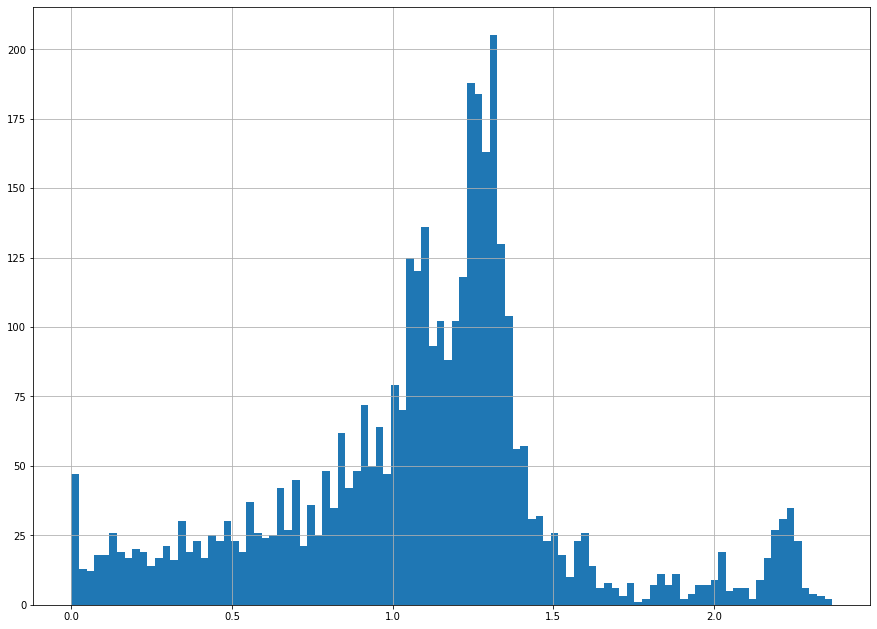

In [110]:
# посмотрим распределение относительно цели
df['ranking_norm'][df['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

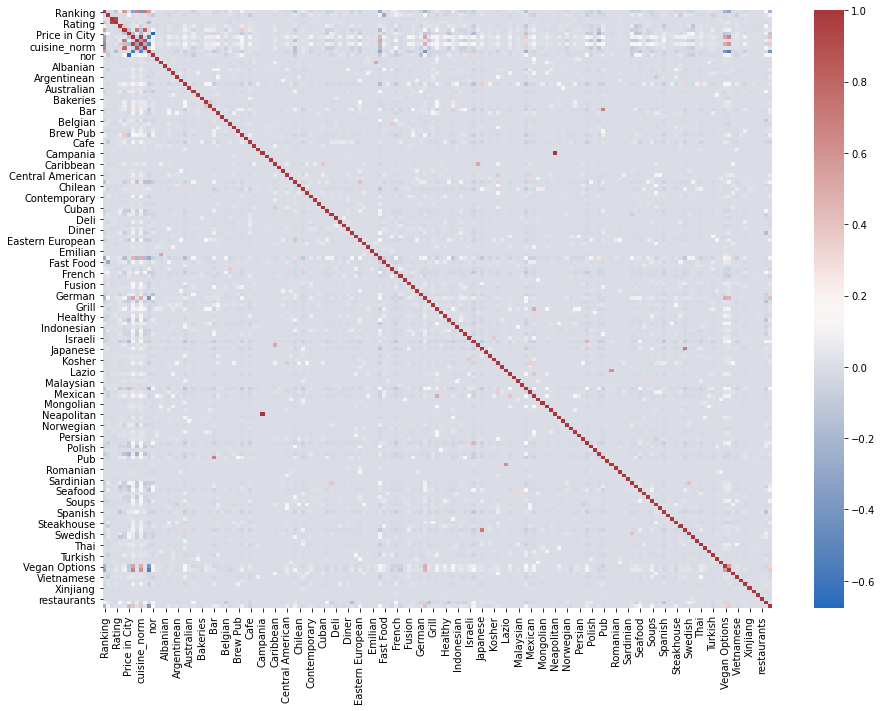

In [111]:
import seaborn as sns 
plt.rcParams['figure.figsize'] = (15,11)
sns.heatmap(df.corr(), cmap='vlag')

In [112]:
# Видим что набор дамми пеерменных дает широту разброса корреляции, но вся основная часть сосредоточена вврху слева)

#делаем бэкап перед созданием нового признака
backup = df
backup.head(3)

,Ranking,Price Range,sample,Rating,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,...,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants,city_le,Number of REviews,Restaurant_id
0,12963.0,2.0,0,0.0,1,2.148,1.926981,2,114.0,0.017544,...,0,0,0,0,0,0,0,24,4.0,id_0
1,106.0,2.0,0,0.0,1,0.655,1.911579,5,80.0,0.062500,...,0,0,0,0,0,0,0,12,97.0,id_1
2,810.0,2.0,0,0.0,0,0.488,1.766443,1,73.0,0.013699,...,0,0,0,0,0,0,0,9,28.0,id_2


AttributeError: 'DataFrame' object has no attribute 'City'

In [48]:
#улучшили еще чуть-чуть
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants,city_le
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,24
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,1,0,0,0,0,0,0,0,0,12
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,1,0,0,0,0,0,0,0,0,9


In [52]:
df.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants,city_le
0,id_0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,24


<H1>Data Preprocessing</H1>

In [68]:


#drop_columns = ['Restaurant_id','City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#df.drop(columns = drop_columns, inplace=True)
df_preproc = df

df_preproc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 164 entries, Ranking to city_le
dtypes: float64(9), int32(1), int64(4), uint8(150)
memory usage: 12.3 MB


In [69]:

missing_data(df)

% пропусков в Ranking 0.0
% пропусков в Price Range 0.0
% пропусков в sample 0.0
% пропусков в Rating 0.0
% пропусков в capital 0.0
% пропусков в population 0.0
% пропусков в Price in City 0.0
% пропусков в col_cuisine 0.0
% пропусков в city_col_cuisine 0.0
% пропусков в cuisine_norm 0.0
% пропусков в city_restaurants 0.0
% пропусков в ranking_norm 0.0
% пропусков в nor 0.0
% пропусков в Afghani 0.0
% пропусков в African 0.0
% пропусков в Albanian 0.0
% пропусков в American 0.0
% пропусков в Arabic 0.0
% пропусков в Argentinean 0.0
% пропусков в Armenian 0.0
% пропусков в Asian 0.0
% пропусков в Australian 0.0
% пропусков в Austrian 0.0
% пропусков в Azerbaijani 0.0
% пропусков в Bakeries 0.0
% пропусков в Balti 0.0
% пропусков в Bangladeshi 0.0
% пропусков в Bar 0.0
% пропусков в Barbecue 0.0
% пропусков в Basque 0.0
% пропусков в Belgian 0.0
% пропусков в Bites 0.0
% пропусков в Brazilian 0.0
% пропусков в Brew Pub 0.0
% пропусков в British 0.0
% пропусков в Burmese 0.0
% пропусков в

In [70]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)


In [71]:

display(train_data.sample(5))
display(test_data.sample(5))
display(y)
display(X)

,Ranking,Price Range,Rating,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants,city_le
16134,1633.0,2.0,4.5,0,1.488,1.944105,1,86.0,0.011628,1145,...,0,0,0,0,0,0,0,0,0,21
35448,1082.0,2.0,4.0,0,0.488,1.766443,4,73.0,0.054795,745,...,1,0,1,0,0,0,0,0,0,9
42659,130.0,2.0,4.5,0,1.488,1.944105,3,86.0,0.034884,1145,...,1,0,0,0,0,0,0,0,0,21
22372,5122.0,2.0,4.5,1,3.334,1.916077,0,106.0,0.000000,3813,...,0,0,0,0,0,0,0,0,0,19
42284,426.0,2.0,4.0,0,1.845,1.940135,4,85.0,0.047059,1186,...,0,0,0,0,0,0,0,0,0,11


,Ranking,Price Range,Rating,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants,city_le
5074,1390.0,2.0,0.0,1,1.750,1.807052,1,81.0,0.012346,1021,...,0,0,0,0,0,0,0,0,0,6
9772,4492.0,2.0,0.0,1,3.669,1.862477,0,108.0,0.000000,2705,...,0,0,0,0,0,0,0,0,0,3
6110,299.0,2.0,0.0,0,0.518,1.944938,3,87.0,0.034483,1126,...,0,0,0,0,0,0,0,0,0,18
403,1120.0,1.0,0.0,1,1.173,1.839713,3,78.0,0.038462,836,...,0,0,0,0,0,0,0,0,0,8
3675,1048.0,1.0,0.0,1,0.506,1.822101,1,82.0,0.012195,1647,...,0,0,0,0,0,0,0,0,0,14


array([3.5, 4. , 4.5, ..., 4.5, 4. , 3. ])

,Ranking,Price Range,capital,population,Price in City,col_cuisine,city_col_cuisine,cuisine_norm,city_restaurants,ranking_norm,...,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,bars,restaurants,city_le
10000,5570.0,2.0,1,2.1480,1.926981,3,114.0,0.026316,6108,0.911919,...,0,0,0,0,0,0,0,0,0,24
10001,1537.0,2.0,1,0.9750,1.969022,2,85.0,0.023529,1033,1.487899,...,0,0,0,0,0,0,0,0,0,27
10002,353.0,3.0,1,8.9610,1.861949,7,120.0,0.058333,7193,0.049075,...,1,0,0,0,0,0,0,0,0,16
10003,3458.0,2.0,1,3.6690,1.862477,0,108.0,0.000000,2705,1.278373,...,0,0,0,0,0,0,0,0,0,3
10004,621.0,2.0,0,1.4880,1.944105,3,86.0,0.034884,1145,0.542358,...,1,0,0,0,0,0,0,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2.0,0,1.1399,1.845583,4,100.0,0.040000,2694,0.185598,...,1,0,0,0,0,0,0,0,0,20
49996,6341.0,2.0,1,2.1480,1.926981,5,114.0,0.043860,6108,1.038147,...,1,0,0,0,0,0,0,0,0,24
49997,1652.0,2.0,1,0.9750,1.969022,2,85.0,0.023529,1033,1.599226,...,0,0,0,0,0,0,0,0,0,27
49998,641.0,2.0,1,1.7930,1.886486,5,81.0,0.061728,925,0.692973,...,1,0,0,0,0,0,0,0,0,29


In [83]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [84]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape, y_train.shape

((10000, 163),
 (40000, 163),
 (40000, 162),
 (30000, 162),
 (10000, 162),
 (30000,))

<H1>ML</H1>

In [87]:


# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


y_pred = (y_pred * 2).round()/2


# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s


MAE: 0.2693


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [88]:
test_data = test_data.drop(['Rating'], axis=1)


In [89]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [77]:
#drop_columns = ['City', 'Cuisine Style', 'Reviews', 'URL_TA','ID_TA']
#print('Смотрим на предикт с базовыми признаками до очистки и генерации новых\n')
#learn_fit(test_data.drop(columns = drop_columns).dropna(), random_state=322)
#test_data

In [90]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [91]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 3.5, 4.5])

In [92]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
